# Data Generation for Multi-stage Tandem Queues

In [146]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import csv, copy
from tqdm import tqdm
import os
import nested_dict as nd

## Single Queue as Building Blocks


In [147]:
class Job:
    def __init__(self, Ta, Ts, index):
        length = np.size(Ta)
        Td = np.zeros(length)
        Tw = np.zeros(length)
        Ba = np.zeros(length)
        Dict = {}
        for i in range(len(Ta)):
            Dict[index[i]]= {'Ta':Ta[i], 'Td':Td[i], 'Ts':Ts[i], 'Tw':Tw[i], 'Ba':Ba[i]}
        
        self.dict = Dict
#         self.dict = dict(zip(index, np.hstack((Ta, Td, Ts, Tw, Ba))))
        # Dictionary values:  1-ArrivalTime 2-DepartureTime 3-ServiceTime 4-WaitingTime 5-BackloggUponArrival 
def MultiServQueue(job, N):
    jobMatrix = np.array(job.dict.values())
    jobIndex = np.array(job.dict.keys())
    length = len(jobIndex)
    order = np.argsort(np.array([f['Ta'] for f in jobMatrix]).flatten())
    Ta = np.array([f['Ta'] for f in jobMatrix])[order]
    Ts = np.array([f['Ts'] for f in jobMatrix])[order]
    jobIndexOrdered = jobIndex[order]
    indexout = []
    f = Ta[0:N] + Ts[0:N]
    les_f = Ta[0:N]
    d = sorted(f)
    e = sorted(les_f)
    index = jobIndexOrdered[np.argsort(f)]
    backlogD = [[0, 0, 0]]
    backlogA = []
    jobDepCum = []
    jobEsCum = []

    for i in tqdm(range(0, length)):
        JobDep, d = d[0], np.delete(d, 0)
        Es, e = e[0], np.delete(e, 0)
        indexout = np.append(indexout, index[0])
        index = np.delete(index, 0)

        jobDepCum.append(JobDep)
        jobEsCum.append(Es)

        tempOcc = float(np.sum(Ta <= JobDep) - (i + 1))
        backlogD.append([JobDep, max(tempOcc - N, 0.0), tempOcc])
        tempOcc = float(i + 1 - np.sum(jobDepCum <= Ta[i]))
        backlogA.append([Ta[i], max(tempOcc - N, 0.0), tempOcc])
        job.dict[jobIndex[i]]['Ba'] = np.round(max(i - np.sum(jobDepCum <= Ta[i]), 0))
        # num of customors in the system (including servers) right upon i'th arrival

        if i <= length - N - 1:
            F = max(Ta[N + i], JobDep) + Ts[N + i]
            u = np.append(F, d)
            u = np.maximum(u, F)
            addedIndex = np.sum(u == F) - 1
            d = np.minimum(np.append(d, np.inf), u)
            index = np.append(index[:addedIndex], np.append(jobIndexOrdered[N + i], index[addedIndex:]))
            e = np.append(e, max(Ta[N + i], JobDep))

        job.dict[indexout[-1]]['Td'] = JobDep
#         job.dict[indexout[-1]][3]= max(0 , JobDep - job.dict[indexout[-1]][0]) # delay (Sojourn)
        job.dict[indexout[-1]]['Tw'] = max(0.0, JobDep - job.dict[indexout[-1]]['Ta'] - job.dict[indexout[-1]]['Ts'])  # waiting

    jobEsCum = np.array(jobEsCum)

    backlogA = np.concatenate((backlogA, backlogD))
    backlogA = np.array(sorted(backlogA, key=lambda x: x[0]))
    job.b = backlogA
    job.index = indexout.astype(int)

## Defining Different Arrival Processes


In [148]:
def MarkovOnOff(length, Alpha, Beta, Lambda):  # Alpha = off-> on | Beta = on -> off
    s = 1
    interArr = np.zeros(length)
    i = 0
    while i < length:

        state_stay = np.random.exponential(1 / Beta)
        elapsed_time = 0
        while s and i < length:
            temp = np.random.exponential(1/Lambda)
            elapsed_time = elapsed_time + temp
            if elapsed_time < state_stay:
                interArr[i] = interArr[i] + temp
                i += 1
            else:
                interArr[i] = interArr[i] + state_stay - (elapsed_time - temp)
                s = 0
        if not s and i < length:
            state_stay = np.random.exponential(1 / Alpha)
            interArr[i] = interArr[i] + state_stay
            s = 1
    Ta = np.cumsum(interArr)
    return Ta


def DetOnOff(length, Ton, Toff, Ta_ON):
    Num_ON = int(Ton/Ta_ON)
    Num_OFF = int(Toff/Ta_ON)
    inter_arr = []
    i = 0
    while i < length-Num_ON:
            inter_arr = np.append(inter_arr, Ta_ON * np.ones(Num_ON-1))
            inter_arr = np.append(inter_arr, Ta_ON * Num_OFF)
            i += Num_ON
    inter_arr = np.append(inter_arr, Ta_ON * np.ones(length-i))
    Ta = np.cumsum(inter_arr)
    return Ta

def DetVarRate(length, t_on1, t_on2, t_a1, t_a2):
    Num_ON1 = int(t_on1/t_a1)
    Num_ON2 = int(t_on2/t_a2)
    inter_arr = []
    i = 0
    while i < length-Num_ON1-Num_ON2:
            inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
            inter_arr = np.append(inter_arr, t_a2 * np.ones(Num_ON2))
            i += Num_ON1+Num_ON2
    if length-i > Num_ON1:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(Num_ON1))
        inter_arr = np.append(inter_arr, t_a2 * np.ones(length-i-Num_ON1))
    else:
        inter_arr = np.append(inter_arr, t_a1 * np.ones(length - i))
    Ta = np.cumsum(inter_arr)
    return Ta


def NonHomPoisson(length, Lambda, lambda_u):
    Ta = []
    t = 0
    l = 0
    while l < length:
        t = t + np.random.exponential(1/lambda_u)
        if np.random.uniform(0, 1) < Lambda(t)/lambda_u:
            Ta.append(t)
            l += 1
    Ta = np.array(Ta)
    return Ta

## Initialization

In [149]:
training = 1 # set to one(zero) for generating training(test) data
ArrivalType = "NonHomPoisson"  # Passenger or 'M' or 'H2'
ServiceType = "logNorm"  # M or logNorm
rho = 0.95
TotHistLength = 5
N = 10*[3]
stageNum = len(N)
mean_Ts = 1*np.ones(10)
mean_Ta = mean_Ts[0] / (N[0] * rho)
day = 24*12
# time_step = 24*60.0/day # Time unit (mins)
if training:
    duration = 20 * day
else:
    duration = 10 * day
lengthTa = int(duration / mean_Ta)
train_length = int(20 * day / mean_Ta)
samplePathLen = int(5 * day / mean_Ta)
test_length = int(10 * day / mean_Ta) 
plot_flag = 1
c_a = 2.0

data_directory = '%s_%s' % (ArrivalType, ServiceType)
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

## Defining Arrival and Service Generating Functions

In [150]:
def Arrival_Gen(ArrivalType, mean_Ta, lengthTa):
    if ArrivalType == "M":
        interArr = np.random.exponential(mean_Ta, lengthTa)
        Ta = np.cumsum(interArr)

    elif ArrivalType == "H2":
        c_a = 2.0 #SCV
        p1 = 0.5*(1+((c_a**2-1)/(c_a**2+1))**0.5)
        p2 = 1-p1
        mu1 = 2*p1/mean_Ta
        mu2 = 2*p2/mean_Ta
        coeff1 = (np.random.uniform(0, 1, lengthTa) < p1)
        coeff2 = ~ coeff1
        interArr1 = np.random.exponential(1/mu1, lengthTa)
        interArr2 = np.random.exponential(1 / mu2, lengthTa)
        interArr = coeff1*interArr1 + coeff2*interArr2
        Ta = np.cumsum(interArr)

    elif ArrivalType == "M_ONOFF":
        Alpha = 0.01
        Beta = 0.1
        Lambda = N*rho*(Alpha + Beta)/(Alpha * mean_Ts)
        Ta = MarkovOnOff(lengthTa, Alpha, Beta, Lambda)
    elif ArrivalType == "DetOnOff":
        T_period = day #/ 24.0  # i.e. E[s] = 5min
        ON_ratio = 0.75
        T_on = ON_ratio * T_period
        T_off = T_period - T_on
        Ta_on = mean_Ta * ON_ratio # (mean_Ts/(N*rho)) * ON_ratio
        Ta = DetOnOff(lengthTa, T_on, T_off, Ta_on)
    elif ArrivalType == "DetVarRate":
        t_on1, t_on2 = 10.0, 10.0
        t_a1, t_a2 = .1, 1
        Ta = DetVarRate(lengthTa, t_on1, t_on2, t_a1, t_a2)
    elif ArrivalType == 'NonHomPoisson':
        alpha = 0.5 #relative amplitude
        lambda_bar = 1 / mean_Ta
        lambda_u = lambda_bar * (1 + alpha)
        Gamma = day#cycle life
        Lambda = lambda t: lambda_bar + lambda_bar * alpha * np.sin(2*np.pi*t/Gamma)
        Ta = NonHomPoisson(lengthTa, Lambda, lambda_u)
    return Ta

def Service_Gen(ServiceType, mean_Ts, lengthTa):
    Ts = []
    if ServiceType == "M": #exponential
        Ts = np.random.exponential(mean_Ts, lengthTa)

    elif ServiceType == "logNorm":  # for lognormal service
        c_s = 1.0 #SCV
        sigma = np.log(1+c_s**2)**0.5
        mu = np.log(mean_Ts) - (sigma**2)/2.0
        Ts = np.exp(np.random.normal(mu, sigma, lengthTa))
    return Ts

## Running Simulations with the Generated Processes

100%|██████████| 16416/16416 [00:19<00:00, 827.65it/s]


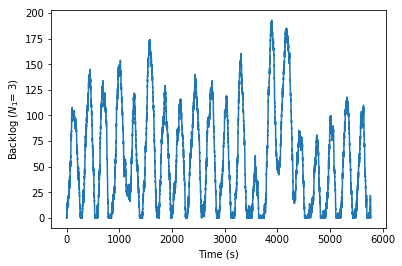

100%|██████████| 16416/16416 [00:19<00:00, 849.43it/s]


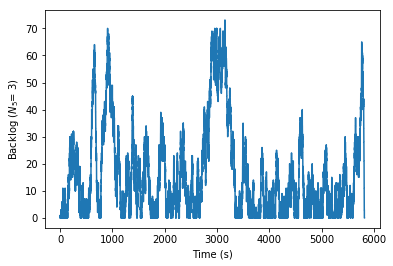

100%|██████████| 16416/16416 [00:21<00:00, 777.45it/s]


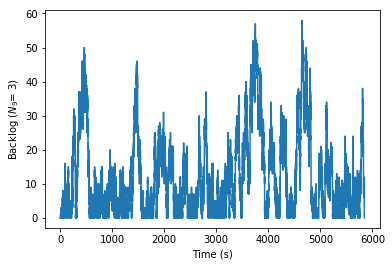

100%|██████████| 16416/16416 [00:20<00:00, 820.73it/s]


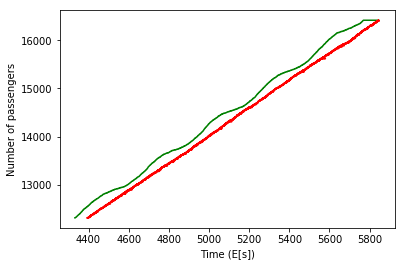

In [151]:
Ta = Arrival_Gen(ArrivalType, mean_Ta, lengthTa)
Ts = Service_Gen(ServiceType, mean_Ts[0], lengthTa)
job = Job(Ta, Ts, np.arange(1, lengthTa + 1))

for stage in range(stageNum):
    
    MultiServQueue(job, N[stage])
    jobMatrix = np.array(job.dict.values())
    jobIndex = np.array(job.dict.keys())
    if stage > 0: 
        assert np.sum(jobIndex-jobIndexOld)==0,"The order of the jobs are not transfered correctly"
    jobIndexOld = copy.copy(jobIndex)

    arrival_time = np.array([f['Ta'] for f in jobMatrix])
    service_time = np.array([f['Ts'] for f in jobMatrix])
    waiting_time = np.array([f['Tw'] for f in jobMatrix])
    departure_time = np.array([f['Td'] for f in jobMatrix])
    
    if stage%(int((stageNum-1)/2))==0:
        plt.figure()
        plt.step(*zip(*job.b[:,:2]), where='post')
        plt.ylabel('Backlog ($N_{%s}$= %s)'%(stage+1, N[stage]))
        plt.xlabel('Time (s)')
        plt.show()

    if stage==0:
        totalJobMatrix = np.hstack((arrival_time.reshape(-1,1), departure_time.reshape(-1,1),
                                    waiting_time.reshape(-1,1)))
        e2eDelay = waiting_time + service_time
    else:
        totalJobMatrix = np.hstack((totalJobMatrix, departure_time.reshape(-1,1),
                                    waiting_time.reshape(-1,1)))
        e2eDelay = e2eDelay + waiting_time + service_time
    
   # -----------creating job matrix for the next stage----------------------
    if stage+1 < stageNum:
        Ts = Service_Gen(ServiceType, mean_Ts[stage+1], lengthTa)
        for i in range(len(arrival_time)):
            job.dict[i+1]= {'Ta':departure_time[i], 'Td':0.0, 'Ts':Ts[i], 'Tw':0.0, 'Ba':0.0}
    
X = np.append(np.append(0, totalJobMatrix[:,0]), departure_time[-1])
Y = np.append(range(0, lengthTa + 1), lengthTa)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'g', where='post', label='Cumalative arrival')
X = np.append(0, departure_time)
Y = range(0, lengthTa + 1)
plt.step(X[-samplePathLen:], Y[-samplePathLen:], 'r', where='post', label='Cumulative departure')
plt.ylabel('Number of passengers')
plt.xlabel('Time (E[s])')
plt.show()    

label = np.reshape(e2eDelay,(-1, 1))


## Dataset Preperation & Saving Data

We use LCS (Last Customer to complete Service) features in each stage as delay history.



In [152]:
order = np.argsort(totalJobMatrix[:, 0])
totalJobMatrix = totalJobMatrix[order]
label = label[order]

History = []
Tot_LCS = []
for i in range(lengthTa):
    ta = totalJobMatrix[i, 0]
    for stage in range(stageNum):
#         ------Finding LCS in each stage --------------
        departure_time = copy.copy(totalJobMatrix[:, 2*stage+1])
        departure_time[departure_time > ta] = np.inf
        index = np.argsort(abs(departure_time-ta))[:TotHistLength]
#         ----------------------------------------------
        if np.prod(departure_time[index] < np.inf):
            History.append(totalJobMatrix[:, 2*stage+2][index])
        else:
            History = []
            Tot_LCS = []
            begin = i
            break
#   ------Finding LCS in Tandem Queue --------------
    departure_time = copy.copy(totalJobMatrix[:, 2*stageNum-1])
    departure_time[departure_time > ta] = np.inf
    index = np.argsort(abs(departure_time-ta))[:TotHistLength]
    if np.prod(departure_time[index] < np.inf):
        Tot_LCS.append(label[index])
#   ----------------------------------------------
Tot_LCS = np.reshape(Tot_LCS, (-1, TotHistLength)) 
History = np.reshape(History, (-1, TotHistLength*stageNum)) 
# Dataset Generation
data = totalJobMatrix[begin+1:, 0].reshape(-1, 1) #Arrival Times
for stage in range(stageNum):
    data = np.hstack((data, History[:, stage*TotHistLength:(stage+1)*TotHistLength]))
data = np.hstack((data, label[begin+1:], Tot_LCS))

# ----------------------WRITING DATA----------------------
if training:
    with open(data_directory+'/DelayPredTrainingdata.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data)
    csvFile.close()
else:
    with open(data_directory+'/DelayPredTestdata.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data)
    csvFile.close()
    with open(data_directory+'/samplePath.csv', 'w') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(data[-samplePathLen:, :])
    csvFile.close()


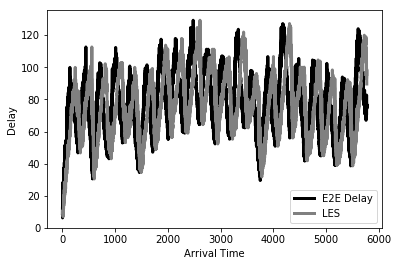

In [153]:
fig = plt.figure()
plt.plot(Ta, label, c='k', lw=3.0, label='E2E Delay')
plt.plot(Ta[begin+1:], Tot_LCS[:, 0], c='0.5', lw=3.0, label='LES')
plt.legend()
plt.xlabel('Arrival Time')
plt.ylabel('Delay')
plt.show()

In [154]:
# import pandas as pd
# Dataset = pd.DataFrame(
# {
#     'Arrival Time' : totalJobMatrix[begin+1:, 0],
#     'History': list(History[:, :2])
# }
# )
# Dataset


# End-to-End Delay Prediction for Tandem Queues (simple feedforward)

In [155]:
from __future__ import absolute_import, division, print_function
import matplotlib
from keras.models import Sequential, model_from_json
from sklearn.metrics import mean_squared_error
import os
import argparse
import csv
from CondDelayDist_funs import *
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from eli5.permutation_importance import get_score_importances

In [156]:
def plot_history(history):
    fig = plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
             label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
             label='Val loss')
    plt.legend()


# Model
def build_model(learning_rate):
    model = Sequential([
        Dense(64, activation=tf.nn.relu, input_shape=(train_data.shape[1],)),
        # Dense(64, activation=tf.nn.relu),
        Dense(32, activation=tf.nn.relu),
        Dense(1, activation=tf.nn.relu),
    ])
    print(model.summary())
    optimizer = tf.train.RMSPropOptimizer(learning_rate)
    model.compile(loss='mse',
                  optimizer=optimizer)
    return model

def score(X, y):
    y_pred = model.predict(X)
    return -mean_squared_error(y_pred, y)

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


## Initialization

In [157]:
learning = 1
learning_rate_range = 10.0 ** -np.arange(4,  4.5, 0.5)
future_step = 1
delayHistLength = 5
feature_num_stage = 1
feature_num = feature_num_stage*stageNum
output_dim = 1
batch_size = 512
Epochs = 300
plot_flag = 1
matlab_mode = (learning == 0)

if matlab_mode == 1:
    import matlab.engine
    eng = matlab.engine.start_matlab()
    
directory = 'Queueing_FeedForward_pred/%s_%s/stepsAhead %d' % (ArrivalType, ServiceType, future_step)
if not os.path.exists(directory):
    os.makedirs(directory)

## Data Preperation

In [158]:
dataSet = np.genfromtxt(data_directory+'/DelayPredTrainingdata.csv', delimiter=',')  # without QLs
Ta_train = dataSet[:, 0]
Tot_LCS_train = dataSet[:, -TotHistLength:]
dataSet = dataSet[:, :-TotHistLength]
dataSet = dataSet[:, -(feature_num * TotHistLength+1):]
# preparing data for learning pairs of (delay, arrival time, ...)
temp = np.zeros((dataSet.shape[0], feature_num * TotHistLength))
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = dataSet[:, k*TotHistLength:TotHistLength*(k+1)]
dataSet[:, -(feature_num * TotHistLength+1):-1] = temp
# picking a history of length #delayHistLength customers with #future_step ahead
# dataSet = np.hstack((Ta_train.reshape(-1, 1), dataSet[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], dataSet[:, -1].reshape(-1, 1)))
dataSet = np.hstack((dataSet[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], dataSet[:, -1].reshape(-1, 1)))

testdata = np.genfromtxt(data_directory+'/DelayPredTestdata.csv', delimiter=',')  # with arrival times
Ta_test = testdata[:, 0]  # arrival times
Tot_LCS_test = testdata[:, -TotHistLength:]
testdata = testdata[:, :-TotHistLength]
testdata = testdata[:, -(feature_num * TotHistLength+1):]
# preparing data for learning pairs of (delay, arrival time)
temp = np.zeros((testdata.shape[0], feature_num * TotHistLength))
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = testdata[:, k*TotHistLength:TotHistLength*(k+1)]
testdata[:, -(feature_num * TotHistLength+1):-1] = temp
# preparing for predicting #future_step ahead predictions
testdata = np.hstack((testdata[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)], testdata[:, -1].reshape(-1, 1)))

samplePath = np.genfromtxt(data_directory+'/samplePath.csv', delimiter=',')
# preparing data for learning pairs of (delay, arrival time)
Ta_samp = samplePath[:, 0]
Tot_LCS_sample = samplePath[:, -TotHistLength:]
samplePath = samplePath[:, :-TotHistLength]
temp0 = samplePath[:, -(feature_num * TotHistLength+1):-1]
temp = np.zeros_like(temp0)
for k in range(feature_num):
    temp[:, range(k, feature_num * TotHistLength, feature_num)] = temp0[:, k*TotHistLength:TotHistLength*(k+1)]
samplePath[:, -(feature_num * TotHistLength+1):-1] = temp
# preparing for predicting #future_step ahead predictions
samplePath = np.hstack((samplePath[:, -feature_num * delayHistLength - ((future_step-1) * feature_num + 1): - ((future_step-1) * feature_num + 1)]
                        , samplePath[:, -1].reshape(-1, 1)))


In [159]:
TotHistLength*(k+1)

50

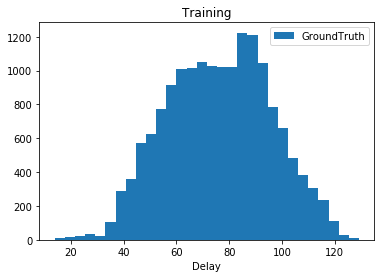

In [160]:
fig = plt.figure()
nbins = 30
plt.hist(dataSet[:, -1], nbins, label=['GroundTruth'])
plt.xlabel('Delay')
plt.legend(loc='upper right')
if training:
    plt.title('Training')
else:
    plt.title('Test')
plt.show()

## Learning and/or Prediction

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 64)                3264      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 33        
Total params: 5,377
Trainable params: 5,377
Non-trainable params: 0
_________________________________________________________________
None

....................................................................................................
....................................................................................................
....................................................................................................Saved model to disk


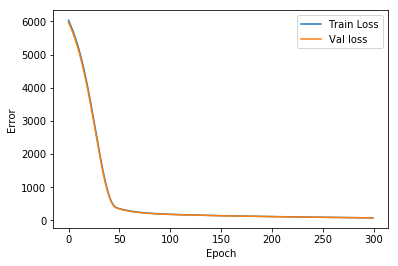

In [161]:
# Shuffle the Dataset set
totSamples = np.shape(dataSet)[0]
order = np.argsort(np.random.random(totSamples))
dataSet = dataSet[order]

train_data = dataSet[:, :-1]
train_labels = dataSet[:, -1]
test_data = testdata[:, :-1]
test_labels = testdata[:, -1]

# Normalizing Features
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std
samplePath_inp = (samplePath[:, :-1] - mean) / std
k = 0
train_err = []
val_err = []
for learning_rate in learning_rate_range:
    model_directory = directory + '/model'
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if learning:
        model = build_model(learning_rate)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model.fit(train_data, train_labels, epochs=Epochs,
                            batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[PrintDot()])

        # serialize model to JSON

        model_json = model.to_json()
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        # load weights into new model
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model.compile(loss='mse',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['mae'])


## Plotting Groundtruth vs Predictions

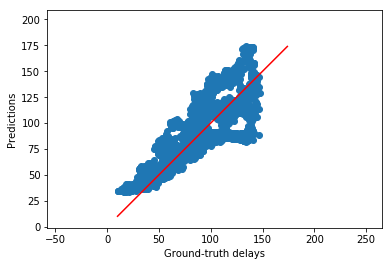

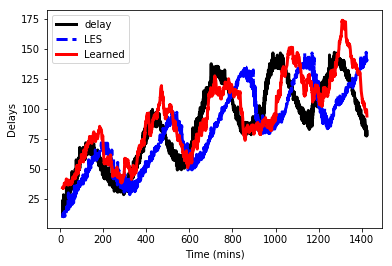

MSE: 321.4609, MSE_LES: 875.9548


In [162]:
# ----------------------Sampling from test_data for plotting---------------------------------
train_len = np.shape(train_data)[0]
test_len = np.shape(test_data)[0]
sampled_data = np.zeros((1, testdata.shape[1]))
# nbins = 10
# sampleNum = 100
# num_per_bin = int(sampleNum / nbins)
# bins = np.linspace(0, max(testdata[:, -1]), nbins + 1)
# for i in range(1, nbins + 1):
#     temp = np.arange(testdata.shape[0])[np.digitize(testdata[:, -1], bins) == i]
#     if len(temp) > 0:
#         choose = np.random.choice(temp, min(num_per_bin, len(temp)), replace=False)
#         sampled_data = np.append(sampled_data, testdata[choose, :], axis=0)
# plot_data = sampled_data[1:, :]
# plot_data_norm = (plot_data[:, :-1] - mean) / std
# sample_len = plot_data.shape[0]
# ///////////////////////////////////////////////////////////////////////////////////
# test_pred = model.predict(plot_data_norm)

# index_sorted_data = np.argsort(plot_data[:, -1])
# sorted_data = plot_data[:, wLES_ind][index_sorted_data]
# sorted_label = plot_data[index_sorted_data, -1]

nbins = 30
z_sim, x_sim, y_sim = np.histogram2d(dataSet[:, -1].flatten(), dataSet[:, -1].flatten(), nbins, normed='True')
# -----------Normalization for getting the conditional distribution------------
eps = 10**-15
z_sim = z_sim/(np.sum(z_sim, axis=0, keepdims=True)+eps)
# -----------calculating centers of the bins-----------
x_sim = (x_sim[:-1]+x_sim[1:])/2.0
y_sim = (y_sim[:-1]+y_sim[1:])/2.0
# -----------Making it ready for the meshplot-----------
x_sim = np.tile(x_sim.reshape(-1, 1), (1, nbins))
y_sim = np.tile(y_sim.reshape(1, -1), (nbins, 1))
# -------------------------------------------------------
if matlab_mode:
    x_sim_m = matlab.double(x_sim.tolist())
    y_sim_m = matlab.double(y_sim.tolist())
    z_sim_m = matlab.double(z_sim.tolist())
    h = eng.figure()
    eng.mesh(x_sim_m, y_sim_m, z_sim_m)
    eng.xlabel('delay')
    eng.ylabel('LES delay')
    eng.title('PDF (Simulated)')
# -----------SCATTER PLOT FOR PREDICTIOMNS-----------
test_pred = model.predict(test_data)
min_range, max_range = min(min(test_labels), min(test_pred)), max(max(test_labels), max(test_pred))
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(test_labels, test_pred)
plt.xlabel('Ground-truth delays')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1, 1.2 * max_range])
plt.ylim([-1, 1.2 * max_range])
plt.plot([min_range, max_range], [min_range, max_range], 'r')
# ----------------------PLOTTING A SAMPLE PATH---------------------------------
samplePath_predictions = model.predict(samplePath_inp)

fig = plt.figure()
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='delay')
plt.plot(Ta_samp, Tot_LCS_sample[:, 0], c='b', lw=3., ls='--', label='LES')
plt.plot(Ta_samp, samplePath_predictions, c='r', lw=3., label='Learned')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Delays')
plt.show()
# ----------------------Comparing the efficiency of LES and RNN model-----------
MSE = mean_squared_error(test_labels, test_pred)
MSE_LES = mean_squared_error(test_labels, Tot_LCS_test[:, 0])
print("MSE: %7.4f, MSE_LES: %7.4f" %(MSE, MSE_LES))

# End-to-End Delay Prediction for Tandem Queues (RNN)


In [163]:
def build_RNN_model(hidden_units, seq_len, feature_num):
    HIDDEN_UNITS = hidden_units
    SEQ_LEN = seq_len
    FEATURE_NUM = feature_num
    model = keras.Sequential()
    model.add(keras.layers.LSTM(HIDDEN_UNITS, batch_input_shape=(None, SEQ_LEN, FEATURE_NUM), return_sequences=True))
    model.add(keras.layers.LSTM(HIDDEN_UNITS))
    model.add(keras.layers.Dense(1, activation=tf.nn.relu))
    model.compile(loss='mse', optimizer=keras.optimizers.Adam())
    model.summary()
    return model

class PrintDot(Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

## Initialization

In [164]:
learning = 1  # set to one(zero) for learning (prediction)
ArrivalType = 'NonHomPoisson'
ServiceType = 'logNorm'
future_step = 1
hidden_units = 64
batch_size = 256
Epochs = 100
matlab_mode = (learning == 0)

if matlab_mode == 1:
    import matlab.engine
    eng = matlab.engine.start_matlab()

directory = 'Queueing_RNN_pred/%s_%s/stepsAhead %d' % (ArrivalType, ServiceType, future_step)
if not os.path.exists(directory):
    os.makedirs(directory)

## Learning and/or Prediction


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 64)             19200     
_________________________________________________________________
lstm_16 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 52,289
Trainable params: 52,289
Non-trainable params: 0
_________________________________________________________________

....................................................................................................Saved model to disk


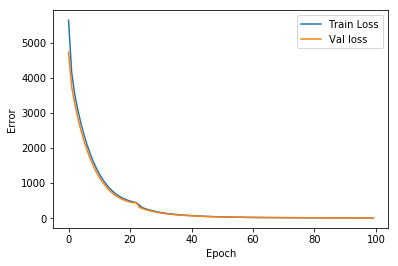

In [165]:
# # Shuffle the Dataset set
# totSamples = np.shape(dataSet)[0]
# order = np.argsort(np.random.random(totSamples))
# dataSet = dataSet[order]

# train_data = dataSet[:, :-1]
# train_labels = dataSet[:, -1]
# test_data = testdata[:, :-1]
# test_labels = testdata[:, -1]

# # Normalizing Features
# mean = train_data.mean(axis=0)
# std = train_data.std(axis=0)
# train_data = (train_data - mean) / std
# test_data = (test_data - mean) / std
# samplePath_inp = (samplePath[:, :-1] - mean) / std
k = 0
train_err = []
val_err = []
for learning_rate in learning_rate_range:
    model_directory = directory + '/model'
    if not os.path.exists(model_directory):
        os.makedirs(model_directory)

    if learning:
        model_RNN = build_RNN_model(hidden_units, delayHistLength, feature_num)
        # Training
        # The patience parameter is the amount of epochs to check for improvement
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        # Store training stats
        history = model_RNN.fit(train_data.reshape(-1, delayHistLength, feature_num), train_labels, epochs=Epochs,
                            batch_size=batch_size, validation_split=0.1, verbose=0, callbacks=[PrintDot()])

        # serialize model to JSON

        model_json = model_RNN.to_json()
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        with open(model_directory + name, "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model_RNN.save_weights(model_directory + name)
        print("Saved model to disk")
        train_err = np.append(train_err, np.array(history.history['loss'])[-1])
        val_err = np.append(val_err, np.array(history.history['val_loss'])[-1])
        plot_history(history)
    else:
        # load json and create model
        name = "/model %s_%s (rho %3.2f).json" % (ArrivalType, ServiceType, rho)
        json_file = open(model_directory + name, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model_RNN = model_from_json(loaded_model_json)
        # load weights into new model
        name = "/weights %s_%s (rho %3.2f).h5" % (ArrivalType, ServiceType, rho)
        model_RNN.load_weights(model_directory + name)
        print("Loaded model from disk")
        # evaluate loaded model on test data
        model_RNN.compile(loss='mse',
                      optimizer=keras.optimizers.Adam(),
                      metrics=['mae'])


## Plotting Ground-truth vs Predictions

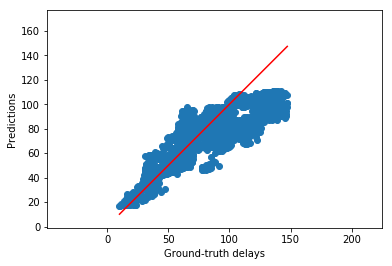

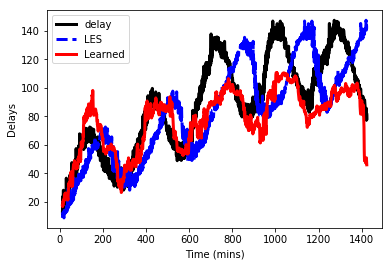

MSE: 484.3106, MSE_LES: 875.9548


In [166]:
# ----------------------Sampling from test_data for plotting---------------------------------
train_len = np.shape(train_data)[0]
test_len = np.shape(test_data)[0]
sampled_data = np.zeros((1, testdata.shape[1]))
# nbins = 10
# sampleNum = 100
# num_per_bin = int(sampleNum / nbins)
# bins = np.linspace(0, max(testdata[:, -1]), nbins + 1)
# for i in range(1, nbins + 1):
#     temp = np.arange(testdata.shape[0])[np.digitize(testdata[:, -1], bins) == i]
#     if len(temp) > 0:
#         choose = np.random.choice(temp, min(num_per_bin, len(temp)), replace=False)
#         sampled_data = np.append(sampled_data, testdata[choose, :], axis=0)
# plot_data = sampled_data[1:, :]
# plot_data_norm = (plot_data[:, :-1] - mean) / std
# sample_len = plot_data.shape[0]
# ///////////////////////////////////////////////////////////////////////////////////
# test_pred = model.predict(plot_data_norm)

# index_sorted_data = np.argsort(plot_data[:, -1])
# sorted_data = plot_data[:, wLES_ind][index_sorted_data]
# sorted_label = plot_data[index_sorted_data, -1]

nbins = 30
z_sim, x_sim, y_sim = np.histogram2d(dataSet[:, -1].flatten(), dataSet[:, -1].flatten(), nbins, normed='True')
# -----------Normalization for getting the conditional distribution------------
eps = 10**-15
z_sim = z_sim/(np.sum(z_sim, axis=0, keepdims=True)+eps)
# -----------calculating centers of the bins-----------
x_sim = (x_sim[:-1]+x_sim[1:])/2.0
y_sim = (y_sim[:-1]+y_sim[1:])/2.0
# -----------Making it ready for the meshplot-----------
x_sim = np.tile(x_sim.reshape(-1, 1), (1, nbins))
y_sim = np.tile(y_sim.reshape(1, -1), (nbins, 1))
# -------------------------------------------------------
if matlab_mode:
    x_sim_m = matlab.double(x_sim.tolist())
    y_sim_m = matlab.double(y_sim.tolist())
    z_sim_m = matlab.double(z_sim.tolist())
    h = eng.figure()
    eng.mesh(x_sim_m, y_sim_m, z_sim_m)
    eng.xlabel('delay')
    eng.ylabel('LES delay')
    eng.title('PDF (Simulated)')
# -----------SCATTER PLOT FOR PREDICTIOMNS-----------
test_pred = model_RNN.predict(test_data.reshape(-1, delayHistLength, feature_num))
min_range, max_range = min(min(test_labels), min(test_pred)), max(max(test_labels), max(test_pred))
fig = plt.figure()
ax = plt.subplot(111)
plt.scatter(test_labels, test_pred)
plt.xlabel('Ground-truth delays')
plt.ylabel('Predictions')
plt.axis('equal')
plt.xlim([-1, 1.2 * max_range])
plt.ylim([-1, 1.2 * max_range])
plt.plot([min_range, max_range], [min_range, max_range], 'r')
# ----------------------PLOTTING A SAMPLE PATH---------------------------------
samplePath_predictions = model_RNN.predict(samplePath_inp.reshape(-1, delayHistLength, feature_num))

fig = plt.figure()
plt.plot(Ta_samp, samplePath[:, -1], c='k', lw=3., label='delay')
plt.plot(Ta_samp, Tot_LCS_sample[:, 0], c='b', lw=3., ls='--', label='LES')
plt.plot(Ta_samp, samplePath_predictions, c='r', lw=3., label='Learned')
plt.legend()
plt.xlabel('Time (mins)')
plt.ylabel('Delays')
plt.show()
# ----------------------Comparing the efficiency of LES and RNN model-----------
MSE = mean_squared_error(test_labels, test_pred)
MSE_LES = mean_squared_error(test_labels, Tot_LCS_test[:, 0])
print("MSE: %7.4f, MSE_LES: %7.4f" %(MSE, MSE_LES))

In [139]:
np.shape(train_data)

(16382, 50)

In [140]:
samplePath_predictions

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.08856654],
       [0.09144922],
       [0.09144922]], dtype=float32)